# 2025 COMP90042 Project

This notebook demonstrates a fact-checking system that verifies claims using evidence passages from a knowledge base. The system first retrieves relevant evidence for each claim and then classifies the claim's veracity based on the evidence. We classify each claim into one of four categories: SUPPORTS, REFUTES, NOT_ENOUGH_INFO, or DISPUTED, according to the evidence found.

We use a provided dataset of claims and evidences:

* Training set: Labeled claims (with ground-truth label and evidence IDs) for model training.
* Development set: Labeled claims for validation and analysis.
* Test set: Unlabeled claims for which we will predict labels.
* Evidence corpus: A JSON knowledge base of evidence passages, indexed by IDs.

The overall workflow is:

1. Data Loading: Read claim datasets and evidence corpus.
2. Evidence Indexing: Preprocess and index evidence texts (using keywords and n-grams) for efficient retrieval.
3. Candidate Retrieval: For each claim, retrieve a shortlist of candidate evidence passages from the index.
4. Retrieval Model Training: Train a BERT-based model to identify relevant evidence among candidates (binary classification).
5. Evidence Retrieval: Use the trained model to select top relevant evidence for each claim.
6. Claim Classification Model Training: Train a BERT-based classifier to predict the claim's label (SUPPORTS/REFUTES/NEI) given claim-evidence pairs.
7. Claim Verification: Apply the classifier to the retrieved evidence for each claim and determine the final label (with logic to handle the DISPUTED case).

# 1.DataSet Processing

First, we load the training and development claims, as well as the evidence corpus. Each claim has an ID, a text, a label (for train/dev), and a list of evidence IDs (the IDs of supporting/refuting evidence passages in the corpus). The evidence corpus is a dictionary mapping evidence IDs to the text of each evidence passage.

In [10]:
import json
import pandas as pd
from pathlib import Path

# # Using Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

# Define data directory and file paths
# DATA_DIR = Path("/root/data")      # Using sever
# RESULT_DIR = Path("/root/result")  # Using sever
DATA_DIR = Path("/content/drive/MyDrive/COMP90042/data")      # Using Google Drive
RESULT_DIR = Path("/content/drive/MyDrive/COMP90042/result")  # Using Google Drive
NER_DIR = RESULT_DIR / "ner"
train_claims_path = DATA_DIR / "train-claims.json"
dev_claims_path   = DATA_DIR / "dev-claims.json"
evidence_path     = DATA_DIR / "evidence.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load the datasets from JSON files
with open(train_claims_path, 'r') as f:
    train_claims = json.load(f)
with open(dev_claims_path, 'r') as f:
    dev_claims = json.load(f)
with open(evidence_path, 'r') as f:
    evidences = json.load(f)

# Print basic information about the datasets
print(f"Number of training claims: {len(train_claims)}")
print(f"Number of development claims: {len(dev_claims)}")
print(f"Number of evidences: {len(evidences)}")

# Display an example training claim and its evidence IDs
example_claim_id, example_claim = next(iter(train_claims.items()))
print("\nExample training claim ID:", example_claim_id)
print("Claim text:", example_claim["claim_text"])
print("Claim label:", example_claim.get("claim_label", "(no label)"))
print("Evidence IDs for this claim:", example_claim["evidences"][:5], "...")


Number of training claims: 1228
Number of development claims: 154
Number of evidences: 1208827

Example training claim ID: claim-1937
Claim text: Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.
Claim label: DISPUTED
Evidence IDs for this claim: ['evidence-442946', 'evidence-1194317', 'evidence-12171'] ...


## Sampling Positive and Negative Training Pairs

In this section, we generate training data for the **evidence retrieval model**.

We create three sets of samples:
1. **Positive samples:** Real claim-evidence pairs from the training set.
2. **Related negative samples:** Evidence used by other claims, but not this one.
3. **Distant negative samples:** Random evidence not linked to any claims.


In [18]:
# Sampling
import numpy as np
np.random.seed(42)  # set random seed for reproducibility

# Prepare lists to accumulate sample pairs
positive_samples = []
related_negative_samples = []
distant_negative_samples = []

# Pre-compute a list of all evidence IDs used in *any* training claim (for related negatives)
all_train_evidence_ids = set()
for cid, claim in train_claims.items():
    for evid in claim["evidences"]:
        all_train_evidence_ids.add(str(evid))
all_train_evidence_ids = list(all_train_evidence_ids)

# Construct positive samples
for claim_id, claim in train_claims.items():
    claim_text = claim["claim_text"]
    for evid_id in claim["evidences"]:
        evid_id = str(evid_id)
        # Only add if the evidence text exists in our evidences dictionary
        if evid_id in evidences:
            positive_samples.append({
                "claim": claim_id,
                "claim_text": claim_text,
                "evidence": evid_id,
                "evidence_text": evidences[evid_id],
                "related": 1  # positive label
            })

# Construct related negative samples
for claim_id, claim in train_claims.items():
    claim_text = claim["claim_text"]
    claim_evids = {str(eid) for eid in claim["evidences"]}
    # Candidates are evidences used by other claims (all train evidence minus this claim's)
    candidates = [e for e in all_train_evidence_ids if e not in claim_evids]
    # Sample the same number of negatives as positive evidences for this claim
    n_needed = len(claim_evids)
    if n_needed > 0:
        sampled = np.random.choice(candidates, size=n_needed, replace=False)
        for evid_id in sampled:
            if evid_id in evidences:
                related_negative_samples.append({
                    "claim": claim_id,
                    "claim_text": claim_text,
                    "evidence": evid_id,
                    "evidence_text": evidences[evid_id],
                    "related": 0  # negative label
                })

# Construct distant negative samples
for claim_id, claim in train_claims.items():
    claim_text = claim["claim_text"]
    claim_evids = {str(eid) for eid in claim["evidences"]}
    # Candidates are all evidences *except* those used by this claim
    candidates = [e for e in evidences.keys() if e not in claim_evids]
    n_needed = len(claim_evids)
    if n_needed > 0:
        sampled = np.random.choice(candidates, size=n_needed, replace=False)
        for evid_id in sampled:
            distant_negative_samples.append({
                "claim": claim_id,
                "claim_text": claim_text,
                "evidence": evid_id,
                "evidence_text": evidences[evid_id],
                "related": 0  # negative label
                })

# Create DataFrames for each set of samples
pos_df = pd.DataFrame(positive_samples)
rel_neg_df = pd.DataFrame(related_negative_samples)
dist_neg_df = pd.DataFrame(distant_negative_samples)

# Concatenate all samples into one DataFrame
combined_samples = pd.concat([pos_df, rel_neg_df, dist_neg_df], ignore_index=True)
print("Positive samples:", pos_df.shape)
print("Related negative samples:", rel_neg_df.shape)
print("Distant negative samples:", dist_neg_df.shape)
print("Total combined samples:", combined_samples.shape)

# Show a few examples of the combined training pairs
combined_samples.head(5)

Positive samples: (4122, 5)
Related negative samples: (4122, 5)
Distant negative samples: (4122, 5)
Total combined samples: (12366, 5)


,claim,claim_text,evidence,evidence_text,related
0,claim-1937,Not only is there no scientific evidence that ...,evidence-442946,At very high concentrations (100 times atmosph...,1
1,claim-1937,Not only is there no scientific evidence that ...,evidence-1194317,Plants can grow as much as 50 percent faster i...,1
2,claim-1937,Not only is there no scientific evidence that ...,evidence-12171,Higher carbon dioxide concentrations will favo...,1
3,claim-126,El Niño drove record highs in global temperatu...,evidence-338219,While ‘climate change’ can be due to natural f...,1
4,claim-126,El Niño drove record highs in global temperatu...,evidence-1127398,This acceleration is due mostly to human-cause...,1


In [21]:
# Save the combined claim-evidence training pairs to a JSON file
output_path = DATA_DIR / "train_claim_evidence_pair_rns.json"
combined_samples.to_json(output_path, orient="records", force_ascii=False)
print(f"Combined training pairs saved to {output_path}")

Combined training pairs saved to /content/drive/MyDrive/COMP90042/data/train_claim_evidence_pair_rns.json



## Evidence Indexing for Candidate Retrieval

Given the extremely large evidence corpus, directly searching through all evidence passages for each claim would be inefficient. Instead, we build an index of the evidence texts to quickly retrieve a manageable number of candidate evidences for each claim. We will use two indexing strategies:

* **Keyword Index**: Extract important keywords (e.g. nouns, proper nouns) from each evidence text using spaCy, and index evidence by these keywords. This allows us to find evidences containing the same key terms as the claim.
* **Character n-gram Index**: Additionally, index each evidence text by character prefixes and suffixes (4-8 characters long) of words. This helps capture partial matches or morphological variations of terms.

Using these indices, for each claim we can retrieve a shortlist of evidence IDs that are likely relevant (share keywords or similar terms), instead of scanning the entire corpus.

In [19]:
# Install spaCy model and other requirements if not already installed (for safety)
!python -m spacy validate
!python -m spacy download en_core_web_sm

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.8.5) =================
ℹ spaCy installation: /usr/local/lib/python3.11/dist-packages/spacy

NAME             SPACY            VERSION                            
en_core_web_sm   >=3.8.0,<3.9.0   3.8.0   ✔

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Text Normalization

Before indexing, we perform some text normalization to standardize terminology (especially for climate-related terms and abbreviations). We define a TextNormalizer that replaces various common terms and symbols with normalized forms (e.g., "CO2" → "carbon dioxide", "°C" → "degree celsius temperature", etc.), removes punctuation, accents, and excess whitespace, and converts text to lowercase. This normalization will be applied to evidence texts when building the index to improve matching.

In [22]:
import re
import spacy
import unicodedata

# Load spaCy model
spacy_model = spacy.load("en_core_web_sm")

# reference:
# https://apps.ipcc.ch/glossary/search.php
# https://blog.energyelephant.com/100-top-carbon-and-climate-acronyms/
# Define a text normalization utility class for standardizing text
class TextNormalizer:
    """A utility class for text normalization and term replacement in climate-related text."""
    def __init__(self):
        self.patterns = [
            # Greenhouse gases and their abbreviations
            (r"\bCO\s*2\b", "carbon dioxide"),
            (r"\bCH\s*4\b", "methane"),
            (r"\bN\s*2\s*O\b", "nitrous oxide"),
            (r"\bNO\b", "nitric oxide"),
            (r"\bNO\s*2\b", "nitrogen dioxide"),
            (r"\bCFCs?\b", "chlorofluorocarbons"),
            (r"\bHFCs?\b", "hydrofluorocarbons"),
            (r"\bGHGs?\b", "greenhouse gases"),
            (r"\bSF\s*6\b", "sulfur hexafluoride"),
            (r"\bPFCs?\b", "perfluorocarbons"),

            # Climate change related terms
            (r"\bRCP\s*([0-9.]+)\b", r"representative concentration pathway \1"),
            (r"\bSSP\s*([0-9.]+)\b", r"shared socioeconomic pathway \1"),
            (r"\bGCMs?\b", "general circulation models"),
            (r"\bGWP\b", "global warming potential"),
            (r"\bERF\b", "effective radiative forcing"),
            (r"\bAR6\b", "sixth assessment report"),
            (r"\bAR5\b", "fifth assessment report"),
            (r"\bAR4\b", "fourth assessment report"),
            (r"\bAR3\b", "third assessment report"),

            # Climate system related terms
            (r"\bENSO\b", "el nino southern oscillation"),
            (r"\bAMOC\b", "atlantic meridional overturning circulation"),
            (r"\bAO\b", "arctic oscillation"),
            (r"\bNAO\b", "north atlantic oscillation"),
            (r"\bPDO\b", "pacific decadal oscillation"),
            (r"\bAMO\b", "atlantic multidecadal oscillation"),
            (r"\bITCZ\b", "intertropical convergence zone"),
            (r"\bMJO\b", "madden julian oscillation"),

            # Organizations and agreements
            (r"\bIPCC\b", "intergovernmental panel on climate change"),
            (r"\bUNFCCC\b", "united nations framework convention on climate change"),
            (r"\bCOP\s*(\d+)\b", r"conference of the parties \1"),
            (r"\bNDCs?\b", "nationally determined contributions"),
            (r"\bREDD\+?\b", "reducing emissions from deforestation and forest degradation"),
            (r"\bLULUCF\b", "land use land use change and forestry"),
            (r"\bAFOLU\b", "agriculture forestry and other land use"),
            (r"\bSDGs?\b", "sustainable development goals"),
            (r"\bMAPA\b", "most affected people and areas"),

            # Units and symbols
            (r"\bppm\b", "parts per million"),
            (r"\bppb\b", "parts per billion"),
            (r"°\s*N", "degree north latitude"),
            (r"°\s*S", "degree south latitude"),
            (r"°\s*E", "degree east longitude"),
            (r"°\s*W", "degree west longitude"),
            (r"°\s*C", "degree celsius temperature"),
            (r"°\s*F", "degree fahrenheit temperature"),
            (r"%", "percent"),

            # Other processing
            (r"-\B", ""),        # remove hyphen when not at a word boundary (internal hyphens in words)
            (r"[(){}\[\]]+", "") # remove brackets and braces
        ]

    def normalize(self, text: str) -> str:
        """Perform full text normalization:
        - Replace special terms and abbreviations
        - Remove punctuation and diacritical marks
        - Normalize whitespace
        - Convert to lowercase
        - Compress repeated punctuation (e.g. "!!" -> "!")"""
        # Apply term replacements (case-insensitive)
        for pattern, repl in self.patterns:
            text = re.sub(pattern, repl, text, flags=re.IGNORECASE)
        # Remove diacritical marks (accents)
        text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
        # Remove remaining non-alphanumeric characters (after replacements)
        text = re.sub(r"[^\w\s]", "", text)
        # Normalize spaces and lowercase
        text = ' '.join(text.split())
        text = text.lower()
        return text

# Create a TextNormalizer instance for use in evidence processing
norm = TextNormalizer()

# Example
sample = "The CFC and CH4 levels near 45°N are increasing by 2% annually according to the IPCC."
print("Normalized:", norm.normalize(sample))

Normalized: the chlorofluorocarbons and methane levels near 45degree north latitude are increasing by 2percent annually according to the intergovernmental panel on climate change


## Noun-Based Indexing and Co-occurrence Graph Construction

This section defines tools for extracting **meaningful nouns** from evidence and claim texts, and for building two structures:

1. **Reverse Index (noun → evidence IDs):**
   For each noun, store a set of evidence passages that contain it. This helps quickly retrieve candidate evidence by noun matching.

2. **Noun Co-occurrence Graph (noun ↔ noun):**
   Build a graph showing how often nouns in claims co-occur with nouns in evidences. This is useful for modeling relationships between concepts mentioned in claim-evidence pairs.

We also define a configuration class IndexPaths to manage the paths of all saved index files.

In [23]:
import json
from pathlib import Path
from collections import defaultdict, Counter
from tqdm.auto import tqdm
from dataclasses import dataclass, field
from typing import Dict, Set

# Assuming `spacy_model` and `norm` exist
# spacy_model = spacy.load("en_core_web_sm")
# norm = TextNormalizer()

# Configuration class to manage all related output file paths
@dataclass
class IndexPaths:
    root: Path
    noun_index: Path = field(init=False)
    relation_index: Path = field(init=False)

    def __post_init__(self):
        self.root.mkdir(parents=True, exist_ok=True)
        self.noun_index = self.root / "noun-to-evidence.json"
        self.relation_index = self.root / "train-noun-graph.json"
        self.tagged_evidences = self.root / "noun-compound-noun-evidence.json"
        self.train_fwd_ngram_evidences = self.root / "forward_ngram_evidences.json"
        self.train_rev_ngram_evidences = self.root / "reversed_ngram_evidences.json"
        self.train_shortlist_evidences = self.root / "train_shortlisting_500.json"
        self.dev_shortlist_evidences = self.root / "dev_shortlisting_500.json"

# NounIndexer is the main indexing tool:
# It handles noun extraction, reverse indexing, and co-occurrence graph building
class NounIndexer:
    def __init__(self, model, normalizer: "TextNormalizer", paths: IndexPaths):
        self.model = model          # spaCy model
        self.norm = normalizer      # text normalizer
        self.paths = paths          # output path configuration

    def _is_content_noun(self, tok) -> bool:
        """
        Check if token is a meaningful noun:
        - not a stopword or space
        - POS must be NOUN or PROPN
        - lemma length > 2
        - does not contain digits
        """
        if tok.is_stop or tok.is_space:
            return False
        if tok.pos_ not in {"NOUN", "PROPN"}:
            return False
        if len(tok.lemma_) <= 2:
            return False
        if any(c.isdigit() for c in tok.lemma_):
            return False
        return True

    def _noun_set(self, raw_text: str) -> set[str]:
        """Normalize and tokenize text, then return a set of valid noun lemmas."""
        doc = self.model(self.norm.normalize(raw_text))
        return {tok.lemma_ for tok in doc if self._is_content_noun(tok)}

    def build_reverse_map(self, evid_dict: Dict[str, str]) -> Dict[str, Set[str]]:
        """
        Build a noun-to-evidence index.
        Each noun points to a set of evidence IDs that contain it.
        Returns a dictionary: {noun: set of evidence IDs}
        """
        if self.paths.noun_index.exists():
            with open(self.paths.noun_index) as fh:
                cache = json.load(fh)
            print(f"[INFO] Loaded cached noun→evidence index ({len(cache)} nouns)")
            return {n: set(lst) for n, lst in cache.items()}

        print("[INFO] Creating noun→evidence index from scratch …")
        noun2evid: dict[str, set[str]] = defaultdict(set)

        for evid_id, text in tqdm(evid_dict.items(), desc="Scanning evidences"):
            for noun in self._noun_set(text):
                noun2evid[noun].add(evid_id)

        # Save index to disk
        with open(self.paths.noun_index, "w") as fh:
            json.dump({n: list(s) for n, s in noun2evid.items()}, fh)
        print(f"[INFO] Index saved → {self.paths.noun_index}")
        return noun2evid

    def build_relation_graph(self, pair_df) -> dict[str, Counter]:
        """
        Build a noun co-occurrence graph.
        For each claim-evidence pair, connect each claim noun to each evidence noun.
        Returns a dictionary: {noun: Counter of related nouns}
        """
        if self.paths.relation_index.exists():
            with open(self.paths.relation_index) as fh:
                cache = json.load(fh)
            print(f"[INFO] Loaded cached noun↔noun graph ({len(cache)} nouns)")
            return {n: Counter(c) for n, c in cache.items()}

        print("[INFO] Constructing noun↔noun co-occurrence graph …")
        relations: dict[str, Counter] = defaultdict(Counter)

        for _, row in tqdm(pair_df.iterrows(), total=len(pair_df), desc="Processing pairs"):
            claim_nouns = self._noun_set(row["claim_text"])
            evid_nouns  = self._noun_set(row["evidence_text"])

            # Count co-occurrence between claim and evidence nouns (bidirectional)
            for c in claim_nouns:
                for e in evid_nouns:
                    if c != e:
                        relations[c][e] += 1
                        relations[e][c] += 1

        # Save graph to disk
        with open(self.paths.relation_index, "w") as fh:
            json.dump({n: dict(cnt) for n, cnt in relations.items()}, fh)
        print(f"[INFO] Graph saved → {self.paths.relation_index}")
        return relations


### Building the Evidence Index

We use the `EvidenceProcessor` class to index the evidence corpus. This class performs the following tasks:

- **Extract keyword tags**:  
  It uses spaCy to identify nouns and proper nouns in each normalized evidence passage.  
  These keywords are mapped to a list of evidence IDs that contain them.

- **Build n-gram indices**:  
  It creates two indices that map character prefixes and suffixes (4–8 characters long) of words to evidence IDs that contain those fragments.

The generated indices are saved to disk to avoid repeated computation.  
If index files already exist, the processor will load them instead of rebuilding.

In [4]:
# Define the evidence processor with normalization pipeline
class EvidenceProcessor:
    """
    Processes evidence texts to extract keyword tags and build n-gram indices for retrieval.
    """
    def __init__(self, evidences: dict, normalize_pipeline, result_dir: Path):
        self.evidences = evidences
        self.normalize_pipeline = normalize_pipeline
        self.result_dir = Path(result_dir)
        self.result_dir.mkdir(parents=True, exist_ok=True)
        # Define file paths for cached indices
        self.tagged_path = self.result_dir / "noun-compound-noun-evidence.json"
        self.fwd_path   = self.result_dir / "forward_ngram_evidences.json"
        self.rev_path   = self.result_dir / "reversed_ngram_evidences.json"
        # Initialize internal storage
        self.tagged_evidences = {}  # keyword -> [evidence_ids]
        self.fwd_index = {}        # prefix -> [evidence_ids]
        self.rev_index = {}        # suffix -> [evidence_ids]
        # Load spaCy English model for tokenization and POS tagging
        self.nlp = spacy.load("en_core_web_sm")

    def extract_info_tags(self):
        """Extract noun/proper noun keywords from each evidence text and build the keyword->evidence index (tagged_evidences)."""
        # If cached file exists, load it
        if self.tagged_path.exists():
            with open(self.tagged_path, 'r') as fh:
                self.tagged_evidences = json.load(fh)
            print(f"[INFO] Loaded existing keyword index from {self.tagged_path}")
            return
        # Otherwise, build the index
        tagged_map = {}
        for evid_id, text in self.evidences.items():
            # Normalize text and tokenize with spaCy
            doc = self.nlp(self.normalize_pipeline(text))
            for token in doc:
                if token.pos_ in ("NOUN", "PROPN"):
                    keyword = token.lemma_.lower()
                    tagged_map.setdefault(keyword, set()).add(evid_id)
        # Convert sets to lists for JSON serialization
        tagged_map = {key: list(ids) for key, ids in tagged_map.items()}
        # Save to file
        with open(self.tagged_path, 'w') as f:
            json.dump(tagged_map, f, ensure_ascii=False, indent=2)
        self.tagged_evidences = tagged_map
        print(f"[INFO] Keyword index built and saved to {self.tagged_path}")

    def build_ngram_index(self):
        """Build character n-gram (prefix and suffix) indices from evidence texts."""
        # If indices already exist, load them
        if self.fwd_path.exists() and self.rev_path.exists():
            print(f"[INFO] Loaded existing n-gram index files: {self.fwd_path}, {self.rev_path}")
            return
        fwd_index = {}
        rev_index = {}
        for evid_id, text in self.evidences.items():
            text_norm = self.normalize_pipeline(text)
            for word in text_norm.split():
                if len(word) < 4:
                    continue
                # Generate prefixes and suffixes of length 4 to 8
                for n in range(4, min(9, len(word) + 1)):
                    prefix = word[:n]
                    suffix = word[-n:]
                    fwd_index.setdefault(prefix, set()).add(evid_id)
                    rev_index.setdefault(suffix, set()).add(evid_id)
        # Convert sets to lists and save to files
        fwd_index = {gram: list(ids) for gram, ids in fwd_index.items()}
        rev_index = {gram: list(ids) for gram, ids in rev_index.items()}
        with open(self.fwd_path, 'w') as f:
            json.dump(fwd_index, f)
        with open(self.rev_path, 'w') as f:
            json.dump(rev_index, f)
        print(f"[INFO] N-gram indices built and saved to disk")

        self.fwd_index = fwd_index
        self.rev_index = rev_index

    def retrieve_candidate_evidences_for_claims(self, claims: dict, train_or_dev: str, max_retrieved: int = 500):
        """
        Retrieve up to max_retrieved candidate evidence IDs for each claim based on keyword and n-gram overlap.
        Saves results as {claim_id: [evidence_id, ...]} in a JSON file.
        """
        retrieved = {}
        # Iterate through each claim
        for claim_id, claim_data in claims.items():
            claim_text = claim_data["claim_text"]
            doc = self.nlp(claim_text)
            # Extract content words (nouns and proper nouns) from the claim
            keywords = [token.lemma_.lower() for token in doc if token.pos_ in ("NOUN", "PROPN")]
            # Construct prefixes and suffixes from claim keywords for matching
            ngrams = []
            for word in keywords:
                if len(word) < 4:
                    continue
                for n in range(4, 9):
                    if len(word) >= n:
                        ngrams.append(word[:n])
                        ngrams.append(word[-n:])
            # Score evidences by keyword and n-gram matches (IDF weighted)
            score_dict = {}
            total_evidence_count = len(self.evidences)
            # Score by keyword matches
            for tag in keywords:
                if tag in self.tagged_evidences:
                    evidence_list = self.tagged_evidences[tag]
                    # Compute IDF score for this keyword
                    df = max(len(evidence_list), 1)
                    idf_score = 1.0 if df == 0 else (10 ** 6 / df)  # (Using a large constant instead of log for simplicity)
                    for eid in evidence_list:
                        score_dict[eid] = score_dict.get(eid, 0.0) + idf_score
            # Score by n-gram matches
            for gram in ngrams:
                if gram in self.fwd_index:
                    evidence_list = self.fwd_index[gram]
                    df = max(len(evidence_list), 1)
                    idf_score = 1.0 if df == 0 else (10 ** 6 / df)
                    for eid in evidence_list:
                        score_dict[eid] = score_dict.get(eid, 0.0) + idf_score
                if gram in self.rev_index:
                    evidence_list = self.rev_index[gram]
                    df = max(len(evidence_list), 1)
                    idf_score = 1.0 if df == 0 else (10 ** 6 / df)
                    for eid in evidence_list:
                        score_dict[eid] = score_dict.get(eid, 0.0) + idf_score
            # Take the top-N evidence IDs by score
            top_eids = sorted(score_dict.keys(), key=lambda x: score_dict[x], reverse=True)[:max_retrieved]
            retrieved[claim_id] = top_eids
        # Save the shortlist for this set (train or dev) to a JSON file
        filename = f"{train_or_dev}_shortlisting_{max_retrieved}.json"
        output_path = self.result_dir / filename
        with open(output_path, 'w') as f:
            json.dump(retrieved, f, ensure_ascii=False, indent=2)
        print(f"[INFO] Saved {train_or_dev} candidate evidences to {output_path}")
        return retrieved


### Displaying Noun-to-Evidence Index
In this section, we load or build the noun-to-evidence mapping using the EvidenceProcessor. This mapping connects each extracted noun to the set of evidence IDs that contain it.


In [13]:
from itertools import islice
from pathlib import Path
output_home = Path("/content/drive/MyDrive/COMP90042/result/ner")
paths = IndexPaths(root=output_home)
indexer = NounIndexer(
    model=spacy_model,
    normalizer=norm,
    paths=paths
)
EP = EvidenceProcessor(evidences, norm.normalize, output_home)

# Build / Load tagged_evidences
# Display NOUN -> evidence mapping: noun and the evidence IDs it is associated with (tagged_evidences.json)
if paths.tagged_evidences.exists():
    print(f"[SKIP] Cached file already exists: {paths.tagged_evidences.name}")
    with open(paths.tagged_evidences) as fh:
        tagged_evidences_map = {n: set(lst) for n, lst in json.load(fh).items()}
else:
    print("[NOTICE] Building noun-compound-noun-evidence.json")
    # Build or load the keyword index (noun -> evidence IDs)
    EP.extract_info_tags()

print(f"[STAT] Indexed a total of {len(tagged_evidences_map)} nouns")

sample_noun = next(iter(tagged_evidences_map))
print(f"\nSample noun \"{sample_noun}\" corresponds to {len(tagged_evidences_map[sample_noun])} evidences")

print("Displaying the first 6 nouns and their candidate evidences:\n")
for noun, evid_set in islice(tagged_evidences_map.items(), 6):
    evid_list = sorted(evid_set)
    print(f"Noun: {noun}")
    print(f"  Corresponding evidences (total {len(evid_list)}):")
    for eid in evid_list[:10]:  # Show only the first 10
        print(f"    {eid}")
    if len(evid_list) > 10:
        print(f"    ... (total {len(evid_list)} evidences, truncated display)")
    print()


[SKIP] Cached file already exists: noun-compound-noun-evidence.json
[STAT] Indexed a total of 2071627 nouns

Sample noun "john" corresponds to 11667 evidences
Displaying the first 6 nouns and their candidate evidences:

Noun: john
  Corresponding evidences (total 11667):
    evidence-0
    evidence-1000054
    evidence-1000120
    evidence-1000122
    evidence-1000184
    evidence-1000202
    evidence-1000267
    evidence-1000289
    evidence-1000382
    evidence-1000460
    ... (total 11667 evidences, truncated display)

Noun: john lawes
  Corresponding evidences (total 1):
    evidence-0

Noun: bennet
  Corresponding evidences (total 20):
    evidence-0
    evidence-1015579
    evidence-1025313
    evidence-1064786
    evidence-1086936
    evidence-178499
    evidence-339484
    evidence-462809
    evidence-584985
    evidence-661380
    ... (total 20 evidences, truncated display)

Noun: bennet lawes
  Corresponding evidences (total 1):
    evidence-0

Noun: english
  Corresponding e

In [14]:

import re

path = paths.train_fwd_ngram_evidences
pattern = re.compile(r'"[^"]+"\s*:\s*\[')

count = 0
carry = ""  # Used to preserve the trailing characters from the previous chunk
chunk_size = 64 * 1024  # Read 64KB per chunk for file processing

# Count the number of forward n-gram entries in the evidence
if paths.train_fwd_ngram_evidences.exists():
    print(f"[SKIP] Cached file already exists: {paths.train_fwd_ngram_evidences.name}")
    with open(path, 'r') as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            data = carry + chunk
            # Match the current concatenated chunk
            matches = pattern.findall(data)
            count += len(matches)
            # Preserve the last 100 characters to avoid splitting keys
            carry = data[-100:]
else:
    print("[NOTICE] Building forward/reversed_ngram_evidences.json")
    EP.build_ngram_index()

print(f"[STAT] Total of {count} forward n-gram entries")

# Build / Load train_rev_ngram_evidences
path = paths.train_rev_ngram_evidences
pattern = re.compile(r'"[^"]+"\s*:\s*\[')

count = 0
carry = ""
chunk_size = 64 * 1024

# Count the number of reverse n-gram entries in the evidence
if paths.train_rev_ngram_evidences.exists():
    print(f"[SKIP] Cached file already exists: {paths.train_rev_ngram_evidences.name}")
    with open(path, 'r') as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            data = carry + chunk
            matches = pattern.findall(data)
            count += len(matches)
            carry = data[-100:]
else:
    print("[NOTICE] Building forward/reversed_ngram_evidences.json")
    EP.build_ngram_index()

print(f"[STAT] Total of {count} reverse n-gram entries")

[SKIP] Cached file already exists: forward_ngram_evidences.json
[STAT] Total of 1287932 forward n-gram entries
[SKIP] Cached file already exists: reversed_ngram_evidences.json
[STAT] Total of 1293164 reverse n-gram entries


### Evidence Shortlisting Output
After this step (shortlisting), we have two files:
- train_shortlisting_500.json – for each training claim, a list of up to 500 candidate evidence IDs likely to be relevant.
- dev_shortlisting_500.json – similarly, candidate evidences for each dev claim.

These shortlists dramatically reduce the search space for each claim, focusing on evidences with overlapping keywords or terms. For instance, the example claim might have a few hundred candidate evidences (instead of over a million) after this step.


In [17]:
# Build / Load shortlist_evidences
if paths.train_shortlist_evidences.exists():
    print(f"[SKIP] Cached file already exists: {paths.train_shortlist_evidences.name}")
    with open(paths.train_shortlist_evidences) as fh:
        train_shortlist_evidences_map = {n: set(lst) for n, lst in json.load(fh).items()}
else:
    print("[NOTICE] Building train_shortlist_evidences.json")
    train_shortlist_evidences_map = EP.retrieve_candidate_evidences_for_claims(train_claims)

print(f"[STAT] Indexed a total of {len(train_shortlist_evidences_map)} claims")

sample_claim = next(iter(train_shortlist_evidences_map))
print(f"\nSample claim \"{sample_claim}\" corresponds to {len(train_shortlist_evidences_map[sample_claim])} evidences")

print("Displaying the first 5 claims and their candidate evidences:\n")
for claim_id, evid_set in islice(train_shortlist_evidences_map.items(), 5):
    evid_list = sorted(evid_set)
    print(f"Claim: {claim_id}")
    print(f"  Candidate evidences (total {len(evid_list)}):")
    for eid in evid_list[:10]:  # Display only the first 10
        print(f"    {eid}")
    if len(evid_list) > 10:
        print(f"    ... (total {len(evid_list)} evidences, truncated display)")
    print()


[SKIP] Cached file already exists: train_shortlisting_500.json
[STAT] Indexed a total of 1228 claims

Sample claim "claim-1937" corresponds to 488 evidences
Displaying the first 5 claims and their candidate evidences:

Claim: claim-1937
  Candidate evidences (total 488):
    evidence-100018
    evidence-100171
    evidence-1002574
    evidence-1005062
    evidence-100551
    evidence-100625
    evidence-1007748
    evidence-1008043
    evidence-1009038
    evidence-1009391
    ... (total 488 evidences, truncated display)

Claim: claim-126
  Candidate evidences (total 490):
    evidence-1000255
    evidence-1004316
    evidence-1005847
    evidence-1006244
    evidence-1006262
    evidence-1007748
    evidence-1009195
    evidence-1011357
    evidence-1017598
    evidence-1022914
    ... (total 490 evidences, truncated display)

Claim: claim-2510
  Candidate evidences (total 450):
    evidence-1004316
    evidence-1006262
    evidence-1012734
    evidence-1014738
    evidence-1014818
  

### Sampling and Dataset Construction for Evidence Retrieval
This section prepares data for training and evaluating the evidence retrieval model, which classifies whether a claim-evidence pair is related.

The key components include:
1. Sample class: A data container that stores a claim, an evidence passage, their IDs, and the label.

2. Sampling functions:
 - _build_samples: Creates labeled pairs (positive and negative) based on shortlist and evidence data.

 - generate_retrieval_data: Generates training data from a shortlist.

 - generate_dev_eval_data: Generates evaluation data with random negative samples.

3. RetrieverListDataset: Wraps the samples into a PyTorch Dataset to enable batching and data loading.

In [19]:
import json
import logging
import random
from pathlib import Path
from typing import List, Dict, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
from torch.utils.data import Dataset
import torch

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# Sample class for storing a single training or evaluation instance
@dataclass(frozen=True)
class Sample:
    claim_text: str
    evidence_text: str
    label: torch.Tensor
    claim_id: str
    evidence_id: str

# Load a JSON file into a Python dictionary
def load_json(path: Path) -> Dict:
    with open(path, 'r') as f:
        return json.load(f)

# Merge multiple JSON files into one dictionary
def merge_jsons(paths: List[Path]) -> Dict:
    merged = {}
    for p in paths:
        merged.update(load_json(p))
    return merged

# Main function to construct positive and negative samples
def _build_samples(
    claims: Dict[str, Dict],
    shortlist: Dict[str, List[str]],
    evidence: Dict[str, str],
    pos_label: int,
    neg_label: int,
    n_neg: int,
    inference: bool,
    shuffle: bool,
    device: torch.device,
    verbose: bool,
    target_claim_id: Optional[str] = None
) -> List[Sample]:
    """
    Construct a list of Sample objects for training or inference.
    Each sample is a (claim, evidence, label) triple.
    """
    samples: List[Sample] = []
    iterator = claims.items()
    if verbose:
        iterator = tqdm(iterator, desc="Building samples")

    for cid, centry in iterator:
        if target_claim_id and cid != target_claim_id:
            continue

        # Add positive samples if not in inference mode
        if not inference:
            for eid in centry.get("evidences", []):
                samples.append(
                    Sample(
                        claim_text    = centry["claim_text"],
                        evidence_text = evidence[eid],
                        label         = torch.tensor(pos_label, device=device),
                        claim_id      = cid,
                        evidence_id   = eid
                    )
                )

        # Add negative samples (sample from the shortlist)
        neg_ids = shortlist.get(cid, []).copy()
        if shuffle:
            random.shuffle(neg_ids)

        picked = 0
        positives = set(centry.get("evidences", []))
        for eid in neg_ids:
            if picked >= n_neg:
                break
            if eid in positives:
                continue
            samples.append(
                Sample(
                    claim_text    = centry["claim_text"],
                    evidence_text = evidence[eid],
                    label         = torch.tensor(neg_label, device=device),
                    claim_id      = cid,
                    evidence_id   = eid
                )
            )
            picked += 1

    logger.info("Built %d samples", len(samples))
    return samples

# Public function to generate training data for the retriever model
def generate_retrieval_data(
    claims_paths: List[Path],
    shortlist_paths: List[Path],
    evidence_path: Path,
    *,
    pos_label: int = 1,
    neg_label: int = 0,
    n_neg_samples: int = 10,
    inference: bool = False,
    shuffle: bool = False,
    seed: int = 42,
    verbose: bool = True,
    device: Optional[torch.device] = None,
    target_claim_id: Optional[str] = None
) -> List[Sample]:
    """
    Generate training or inference samples using retrieved evidence shortlist.
    """
    random.seed(seed)
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    claims    = merge_jsons(claims_paths)
    shortlist = merge_jsons(shortlist_paths)
    evidence  = load_json(evidence_path)

    return _build_samples(
        claims, shortlist, evidence,
        pos_label, neg_label,
        n_neg_samples, inference,
        shuffle, device, verbose,
        target_claim_id
    )

# Public function to generate evaluation samples for the dev set
def generate_dev_eval_data(
    dev_claims_path: Path,
    evidence_path: Path,
    *,
    pos_label: int = 1,
    neg_label: int = 0,
    n_neg_samples: int = 10,
    seed: int = 42,
    verbose: bool = True,
    device: Optional[torch.device] = None
) -> List[Sample]:
    """
    Generate evaluation samples by randomly choosing negative evidence IDs
    from the global pool of all evidence used in the dataset.
    """
    random.seed(seed)
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    claims   = load_json(dev_claims_path)
    evidence = load_json(evidence_path)

    # Create a global pool of negative samples (all evidence IDs seen in claims)
    neg_pool = [eid for c in claims.values() for eid in c["evidences"]]
    random.shuffle(neg_pool)

    # Use the same negative pool for every claim
    shortlist = {cid: neg_pool for cid in claims}

    return _build_samples(
        claims, shortlist, evidence,
        pos_label, neg_label,
        n_neg_samples,
        inference=False,
        shuffle=True,
        device=device,
        verbose=verbose
    )

# Wraps a list of Sample objects into a PyTorch Dataset
class RetrieverListDataset(Dataset):
    """
    Wraps a list of Sample objects into a torch Dataset.
    Each item is a tuple: (claim_text, evidence_text, label, claim_id, evidence_id)
    """
    def __init__(self, samples: List[Sample]):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        return s.claim_text, s.evidence_text, s.label, s.claim_id, s.evidence_id


###  Dataset Construction for Label Classification - Prepare

This module constructs training and evaluation datasets for a label classification task in fact verification. It defines a standardized label mapping (`LABEL_MAP`) from claim labels such as `"REFUTES"`, `"SUPPORTS"`, and `"NOT_ENOUGH_INFO"` to integer class indices, which are then used as classification targets.

At its core is the function `generate_label_classification_samples`, which reads claim-evidence data from one or more JSON files (`claims_paths`) and aligns them with textual evidence from an `evidence_path`. For each `(claim, evidence)` pair, a `Sample` dataclass instance is constructed, storing the claim and evidence text, the associated class label as a `torch.Tensor`, and their corresponding IDs. If `training=True`, claims with the label `"DISPUTED"` are excluded.

Once the samples are generated, they are wrapped in a `LabelClassificationListDataset`, which is a simple subclass of `torch.utils.data.Dataset` that allows PyTorch's `DataLoader` to iterate over the samples in mini-batches. The `__getitem__` method returns the text pairs and label in a tuple format suitable for training a neural classifier.

This structure allows seamless integration with PyTorch-based training loops, making it easy to handle large-scale claim-evidence pairs for multi-class classification in tasks such as stance detection or fact verification.

In [ ]:
# Label Classification with BERT Cross-Encoder

# Define directories for data input and output
DATA_DIR = Path("/content/drive/MyDrive/COMP90042/data")
RESULT_DIR = Path("/content/drive/MyDrive/COMP90042/result")
EVIDENCE_PATH = DATA_DIR / "evidence.json"
PREDICT_INPUT_PATH = RESULT_DIR / "ner" / "bert_retriver_claim_evidence.json"
PREDICT_OUTPUT_PATH = DATA_DIR / "test-claims-predictions.json"

# Set the computation device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Label mapping for classification task
LABEL_MAP: Dict[str, int] = {
    "REFUTES": 0,
    "NOT_ENOUGH_INFO": 1,
    "SUPPORTS": 2,
    # "DISPUTED" is not included in training
}

@dataclass(frozen=True)
class Sample:
    """
    Data container for a single claim-evidence-label sample.
    """
    claim_text: str
    evidence_text: str
    label: torch.Tensor
    claim_id: str
    evidence_id: str

def load_json(path: Path) -> Dict:
    """
    Load a single JSON file and return it as a dictionary.
    """
    with open(path, 'r') as f:
        return json.load(f)

def merge_jsons(paths: List[Path]) -> Dict:
    """
    Merge multiple JSON files into a single dictionary.
    """
    merged: Dict = {}
    for p in paths:
        merged.update(load_json(p))
    return merged

def generate_label_classification_samples(
    claims_paths: List[Path],
    evidence_path: Path,
    *,
    training: bool = False,
    verbose: bool = True,
    device: Optional[torch.device] = None
) -> List[Sample]:
    """
    Generate a list of label classification samples.

    Args:
        claims_paths: List of JSON files containing claims (train/dev)
        evidence_path: JSON file containing the evidence corpus
        training: Whether this is used for training (DISPUTED will be filtered out)
        verbose: Whether to display progress with tqdm
        device: The torch device to store the labels on

    Returns:
        A list of Sample objects containing claim-evidence-label pairs.
    """
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load claims and evidence data
    claims   = merge_jsons(claims_paths)
    evidence = load_json(evidence_path)

    samples: List[Sample] = []
    iterator = claims.items()
    if verbose:
        iterator = tqdm(iterator, desc="Building label classification samples")

    for cid, centry in iterator:
        # Get the label string; use NOT_ENOUGH_INFO as default if missing
        label_str = centry.get("claim_label", "NOT_ENOUGH_INFO")
        
        # During training, skip claims with DISPUTED label
        if training and label_str == "DISPUTED":
            continue

        # Convert label string to numeric index
        label_int = LABEL_MAP.get(label_str, LABEL_MAP["NOT_ENOUGH_INFO"])

        # For each associated evidence ID, create a Sample object
        for eid in centry.get("evidences", []):
            samples.append(
                Sample(
                    claim_text   = centry["claim_text"],
                    evidence_text= evidence[eid],
                    label        = torch.tensor(label_int, device=device),
                    claim_id     = cid,
                    evidence_id  = eid
                )
            )

    logger.info("Generated %d classification samples", len(samples))
    return samples

class LabelClassificationListDataset(Dataset):
    """
    Wrap a List[Sample] into a torch-compatible Dataset.

    __getitem__ returns a tuple:
    (claim_text, evidence_text, label_tensor, claim_id, evidence_id)
    """
    def __init__(self, samples: List[Sample]):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        return s.claim_text, s.evidence_text, s.label, s.claim_id, s.evidence_id



### Preparing Training Data for the Evidence Retrieval Model

Using the candidate evidence shortlists, we now prepare training data to train a model that can distinguish relevant evidence from irrelevant ones. We will create positive and negative training examples:

- Positive examples: Pair each claim with each evidence that is actually linked to it (from the ground-truth evidences in the dataset). These are labeled as "related" (1).
- Negative examples: For each claim, pair it with some evidences that are not linked to it. We sample these from the candidate shortlist to ensure they are reasonable negatives (they might be topically related but not actually supporting the claim). These are labeled as "not related" (0).
  
Two types of negatives are used:
  
- **Related-negatives**:  
  Evidences that were used by other claims (so they are real evidence passages but for a different claim).

- **Distant-negatives**:  
  Random evidences that were not used by any claim in the training set.

We generate an equal number of both negative types. This creates a balanced training set for the retrieval classifier.

We use utility functions generate_retrieval_data and generate_dev_eval_data (provided as part of the project code) to automate this process. These functions will read the claim files and shortlist files, and output a list of sample pairs.

In [20]:
# Use the provided utility functions to generate training and validation samples for retrieval
train_samples = generate_retrieval_data(
    claims_paths=[train_claims_path],
    shortlist_paths=[NER_DIR / "train_shortlisting_500.json"],
    evidence_path=evidence_path,
    n_neg_samples=10,   # use 10 negative samples per claim (balanced with positives)
    pos_label=1,
    neg_label=0
)
val_samples = generate_dev_eval_data(
    dev_claims_path=dev_claims_path,
    evidence_path=evidence_path,
    n_neg_samples=3    # a few negatives per dev claim for evaluation
)

# Wrap the samples in PyTorch Dataset objects for loading
train_data = RetrieverListDataset(train_samples)
val_data   = RetrieverListDataset(val_samples)

Building samples:   0%|          | 0/1228 [00:00<?, ?it/s]

Building samples:   0%|          | 0/154 [00:00<?, ?it/s]

# 2.1 Model Implementation - Evidence Retrieval Model

In [ ]:
# PyTorch (if don't have)
# !pip uninstall -y torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torcheval



### Training the Evidence Retrieval Model

We use a BERT-based classifier to predict whether a given claim and evidence pair is related or not. The model (BertRetriever) uses a pretrained BERT (bert-base-uncased) to encode the texts and a linear layer to output a binary classification. We fine-tune this model on our positive/negative samples.


We define a `RetrieverTrainer` to:

- Fine-tune the model using cross-entropy loss  
- Track validation metrics: Accuracy and F1  
- Run for a few epochs with validation on the dev set

This model helps filter out irrelevant evidence and improves the precision of claim verification.

In [ ]:
# Claim-Evidence Retrieval with BERT Cross-Encoder
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics import BinaryAccuracy, BinaryF1Score
from torch.optim.lr_scheduler import LinearLR
from typing import List, Union, Dict, Tuple
from dataclasses import dataclass

import json
import numpy as np
import random
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Define paths
# DATA_DIR = Path("/content/drive/MyDrive/COMP90042/data")
# RESULT_DIR = Path("/content/drive/MyDrive/COMP90042/result")
NER_DIR = RESULT_DIR / "ner"
MODEL_SAVE_PATH = RESULT_DIR / f"bert_retrieval_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"

# Model class for evidence retrieval (BERT with a linear classifier for binary output)
class BertRetriever(nn.Module):
    def __init__(self, pretrained="bert-base-uncased", num_labels=2):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(pretrained)
        self.bert = BertModel.from_pretrained(pretrained)
        self.linear = nn.Linear(768, num_labels)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.to(DEVICE)

    def forward(self, batch_texts, max_length=128, dropout_prob=None):
        # batch_pairs: list of (claim_text, evidence_text) tuples
        encoded = self.tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(DEVICE)
        outputs = self.bert(**encoded)
        pooled = outputs.pooler_output  # pooled [CLS] token representation
        if dropout_prob:
            pooled = nn.Dropout(p=dropout_prob)(pooled)

        logits = self.linear(pooled)
        probs = torch.exp(self.log_softmax(logits))
        return probs, logits


# Trainer class to handle training loop for retrieval model
class RetrieverTrainer:
    def __init__(self, model, train_data, val_data, batch_size=16, lr=5e-6, weight_decay=0.02, warmup=0.1):
        self.model = model
        self.train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=batch_size)
        self.loss_fn = nn.CrossEntropyLoss() # binary cross-entropy loss
        self.optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        # Simple linear warm-up scheduler for demonstration (not critical)
        self.scheduler = LinearLR(self.optimizer, total_iters=int(warmup * len(self.train_loader)))
        self.acc_metric = BinaryAccuracy()
        self.f1_metric = BinaryF1Score()

    def train(self, epochs=3):
        loss_trace, acc_trace, f1_trace = [], [], []
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            self.model.train()
            epoch_loss = 0.0
            for batch in tqdm(self.train_loader):
                claims, evidences, labels, *_ = batch
                # Prepare inputs and labels
                inputs = list(zip(claims, evidences))
                # Forward pass
                _, logits = self.model(inputs, max_length=512, dropout_prob=0.1)
                loss = self.loss_fn(logits, labels.to(DEVICE))
                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(self.train_loader)
            loss_trace.append(avg_loss)
            print(f"Training loss: {avg_loss:.4f}")
            # Evaluate on validation set
            acc, f1 = self.evaluate()
            acc_trace.append(acc)
            f1_trace.append(f1)

        self._plot_metrics(loss_trace, acc_trace, f1_trace)

    def evaluate(self):
        self.model.eval()
        self.acc_metric.reset()
        self.f1_metric.reset()
        for batch in self.val_loader:
            claims, evidences, labels, *_ = batch
            inputs = list(zip(claims, evidences))
            probs, _ = self.model(inputs, max_length=512)
            preds = torch.argmax(probs, dim=1).cpu()
            self.acc_metric.update(preds, labels.cpu())
            self.f1_metric.update(preds, labels.cpu())
        acc = self.acc_metric.compute().item()
        f1 = self.f1_metric.compute().item()
        print(f"Validation Accuracy: {acc:.4f}, F1: {f1:.4f}")
        return acc, f1

    def _plot_metrics(self, losses, accs, f1s):
        plt.plot(losses, label="Loss")
        plt.plot(accs, label="Accuracy")
        plt.plot(f1s, label="F1 Score")
        plt.xlabel("Epoch")
        plt.title("Training Progress")
        plt.legend()
        plt.grid()
        plt.show()


# 2.2 Test and Evaluation - Evidence Retrieval Model

### BERT Retriever Training Summary

This notebook cell trains a BERT-based retriever model (`BertRetriever`) over 3 epochs using the `RetrieverTrainer` class. The training process tracks key metrics including training loss, validation accuracy, and F1 score.

- **Epoch 1** achieves the highest validation F1 score (0.8183), with a training loss of 0.3419.
- **Epochs 2–3** show decreasing training loss, but slightly lower F1 scores, indicating potential early overfitting.
- A plot titled **"Training Progress"** visualizes the trends in loss, accuracy, and F1 score over time.

After training, the model’s weights are saved to MODEL_SAVE_PATH


Epoch 1/3


100%|██████████| 1026/1026 [06:18<00:00,  2.71it/s]


Training loss: 0.3419
Validation Accuracy: 0.8080, F1: 0.8183

Epoch 2/3


100%|██████████| 1026/1026 [06:18<00:00,  2.71it/s]


Training loss: 0.1746
Validation Accuracy: 0.7513, F1: 0.7824

Epoch 3/3


100%|██████████| 1026/1026 [06:17<00:00,  2.72it/s]


Training loss: 0.0922
Validation Accuracy: 0.7345, F1: 0.7517


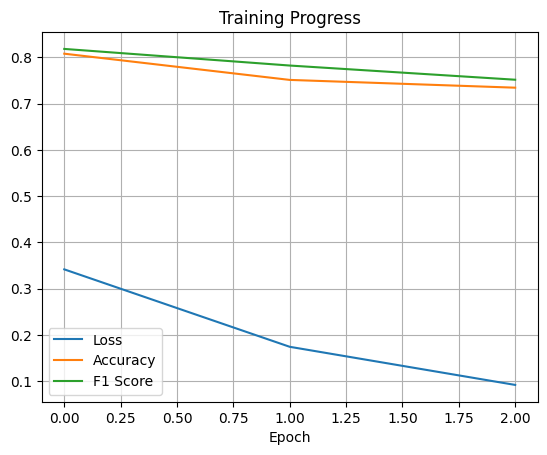

Model saved to /content/drive/MyDrive/COMP90042/result/bert_retrieval_model_20250524_111545.pth


In [ ]:
# Load datasets
# Instantiate and train
model = BertRetriever()
trainer = RetrieverTrainer(model, train_data, val_data)
trainer.train(epochs=3)

# Save model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

### Inference Pipeline for Claim-Evidence Retrieval

This module defines a complete pipeline for performing **claim-evidence retrieval** using a trained BERT-based model.

#### File & Path Configuration
- Loads claims from `test-claims-unlabelled.json` and evidence from `evidence.json`.
- Loads a pretrained model from `bert_retrieval_model_20250524_111545.pth`.
- Uses a shortlist (pre-filtered evidence candidates) from `test_shortlisting_1000.json`.

#### Key Components
- **`RankedEvidence`**: A data class representing an evidence ID and its relevance score.
- **`PredictionCollector`**: Collects predicted evidence for each claim, ranks them by score, and outputs the top-K candidates.
- **`InferenceRunner`**: Encodes input (claim, evidence) pairs and computes softmax scores using the trained model.

#### Retrieval Function: `run_retrieval()`
This function:
1. Generates all possible `(claim, evidence)` pairs based on shortlisting.
2. Feeds batched pairs into the model to get relevance scores.
3. Aggregates scores using `PredictionCollector` and retains the **Top-5** highest-scoring evidence IDs for each claim.
4. Saves the retrieval result to `bert_retriver_claim_evidence.json` in the expected downstream format.

The score used is typically the second class's probability (e.g., `"relevant"` class in binary classification).

This pipeline forms the first stage in a two-step fact verification system: **(1) Evidence Retrieval → (2) Label Classification**.

In [ ]:
# Inference Pipeline for Claim-Evidence Retrieval
import torch
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import json
from typing import List, Dict, Tuple
from dataclasses import dataclass
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
import matplotlib.pyplot as plt


# Path Configuration
NER_DIR = RESULT_DIR / "ner"
CLAIM_FILE = DATA_DIR / "test-claims-unlabelled.json"
EVIDENCE_FILE = DATA_DIR / "evidence.json"
FINAL_OUTPUT = DATA_DIR / "test-claims-predictions.json"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SHORTLIST_PATH = NER_DIR / "test_shortlisting_1000.json"
RETRIEVAL_MODEL_PATH  = RESULT_DIR / "bert_retrieval_model_20250524_111545.pth"
RETRI_SAVE_PATH = RESULT_DIR / "bert_retriver_claim_evidence.json"
# Data Structures
@dataclass
class RankedEvidence:
    evidence_id: str
    score: float


class PredictionCollector:
    def __init__(self):
        self.records = {}

    def add_claim(self, claim_id: str, claim_text: str):
        self.records[claim_id] = {"claim_text": claim_text, "evidences": []}

    def add_evidence(self, claim_id: str, evidence_score: RankedEvidence):
        self.records[claim_id]["evidences"].append(evidence_score)

    def finalize(self, top_k: int = 5) -> Dict:
        final_predictions = {}
        for cid, claim in self.records.items():
            sorted_evidences = sorted(claim["evidences"], key=lambda e: e.score, reverse=True)
            final_predictions[cid] = {
                "claim_text": claim["claim_text"],
                "evidences": [e.evidence_id for e in sorted_evidences[:top_k]]
            }
        return final_predictions



# Inference Utilities
class InferenceRunner:
    def __init__(self, model, tokenizer, max_len=512):
        self.model = model.to(DEVICE)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def predict_scores(self, claim_evidence_pairs: List[Tuple[str, str]]) -> torch.Tensor:
        encoded = self.tokenizer(claim_evidence_pairs, return_tensors='pt', padding=True,
                                 truncation=True, max_length=self.max_len).to(DEVICE)
        with torch.no_grad():
            logits = self.model.bert(**encoded).pooler_output
            logits = self.model.linear(logits)
            probs = torch.softmax(logits, dim=1)
        return probs


# Bert Evidence Retrieval Inference
def run_retrieval(model, tokenizer):
    dataset = generate_retrieval_data(
        claims_paths=[CLAIM_FILE],
        shortlist_paths=[SHORTLIST_PATH],
        evidence_path=EVIDENCE_FILE,
        inference=True,
        n_neg_samples=9999999999
    )
    dataset = RetrieverListDataset(dataset)
    loader = DataLoader(dataset, batch_size=16, shuffle=False)
    runner = InferenceRunner(model, tokenizer)

    collector = PredictionCollector()
    for batch in tqdm(loader, desc="Retrieving Evidence"):
        claims, evidences, _, claim_ids, evidence_ids = batch
        inputs = list(zip(claims, evidences))
        probs = runner.predict_scores(inputs)
        relevance_scores = probs[:, 1].cpu().numpy()
        for cid, eid, score, ctext in zip(claim_ids, evidence_ids, relevance_scores, claims):
            if cid not in collector.records:
                collector.add_claim(cid, ctext)
            collector.add_evidence(cid, RankedEvidence(eid, float(score)))

    retrieval_output = collector.finalize(top_k=5)
    with open(RETRI_SAVE_PATH, "w") as f:
        json.dump(retrieval_output, f)
        print("Saved retrieval results.")
    return retrieval_output


In [ ]:
# Load and run retrieval
retrieval_model = BertRetriever()
retrieval_model.load_state_dict(torch.load(RETRIEVAL_MODEL_PATH, map_location=DEVICE))
retrieval_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
retrieval_results = run_retrieval(retrieval_model, retrieval_tokenizer)

Retrieving Evidence: 100%|██████████| 8151/8151 [17:21<00:00,  7.82it/s]


Saved retrieval results.


# 3.1 Model Implementation - Label Classification Model

### BERT-Based Label Classification Pipeline

This module defines a simple BERT-based model and training workflow for multi-class label classification (e.g., SUPPORTS / REFUTES / NOT_ENOUGH_INFO).

#### `BertLabelClassifier`
- Uses `BertModel` to encode input `[CLS]` token representation.
- Applies a linear layer + `LogSoftmax` to classify into 3 labels.
- Supports dropout during training and returns both logits and probabilities.

#### `LabelTrainer`
- Wraps the model with training and evaluation logic.
- Uses `CrossEntropyLoss`, AdamW optimizer, and a linear warmup scheduler.
- Tracks accuracy and F1 using TorchMetrics.
- Plots loss, accuracy, and F1 over epochs for easy monitoring.

This pipeline enables efficient fine-tuning of BERT for label prediction in claim-evidence classification tasks.

In [ ]:
# Model class
class BertLabelClassifier(nn.Module):
    def __init__(self, pretrained="bert-base-uncased", num_labels=3):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(pretrained)
        self.bert = BertModel.from_pretrained(pretrained)
        self.linear = nn.Linear(768, num_labels)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.to(DEVICE)

    def forward(self, batch_texts, max_length=128, dropout_prob=None):
        tokenized = self.tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(DEVICE)

        pooled = self.bert(**tokenized).pooler_output
        if dropout_prob:
            pooled = nn.Dropout(p=dropout_prob)(pooled)

        logits = self.linear(pooled)
        probs = torch.exp(self.log_softmax(logits))
        return probs, logits

# Trainer class
class LabelTrainer:
    def __init__(self, model, train_data, val_data, batch_size=16, lr=5e-6, weight_decay=0.01, warmup=0.1, label_weights=None):
        self.model = model
        self.train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=batch_size)
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(label_weights, device=DEVICE))
        self.optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = LinearLR(self.optimizer, total_iters=int(warmup * len(self.train_loader)))
        self.acc_metric = MulticlassAccuracy(num_classes=3)
        self.f1_metric = MulticlassF1Score(num_classes=3)

    def train(self, epochs=3):
        loss_trace, acc_trace, f1_trace = [], [], []
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            self.model.train()
            total_loss = 0
            for batch in tqdm(self.train_loader):
                claims, evidences, labels, *_ = batch
                inputs = list(zip(claims, evidences))
                self.optimizer.zero_grad()
                _, logits = self.model(inputs, max_length=512, dropout_prob=0.1)
                loss = self.loss_fn(logits, labels.to(DEVICE))
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(self.train_loader)
            loss_trace.append(avg_loss)
            print(f"Training loss: {avg_loss:.4f}")

            acc, f1 = self.evaluate()
            acc_trace.append(acc)
            f1_trace.append(f1)

        self._plot_metrics(loss_trace, acc_trace, f1_trace)

    def evaluate(self):
        self.model.eval()
        self.acc_metric.reset()
        self.f1_metric.reset()
        for batch in self.val_loader:
            claims, evidences, labels, *_ = batch
            inputs = list(zip(claims, evidences))
            probs, _ = self.model(inputs, max_length=512)
            preds = torch.argmax(probs, dim=1).cpu()
            self.acc_metric.update(preds, labels.cpu())
            self.f1_metric.update(preds, labels.cpu())
        acc = self.acc_metric.compute().item()
        f1 = self.f1_metric.compute().item()
        print(f"Validation Accuracy: {acc:.4f}, F1: {f1:.4f}")
        return acc, f1

    def _plot_metrics(self, losses, accs, f1s):
        plt.plot(losses, label="Loss")
        plt.plot(accs, label="Accuracy")
        plt.plot(f1s, label="F1 Score")
        plt.xlabel("Epoch")
        plt.title("Label Classifier Training")
        plt.legend()
        plt.grid()
        plt.show()

# 3.2 Test and Evaluation - Label Classification Model

### Label Classification Model Training

This cell trains a BERT-based label classifier (`BertLabelClassifier`) to predict the stance of a claim with respect to selected evidence. The dataset is loaded from `train-claims.json` and `dev-claims.json`, with samples preprocessed using `generate_label_classification_samples()`.

#### Training Details
- The model is trained using `LabelTrainer` over **5 epochs**.
- Class imbalance is addressed with label weights: `[1.0, 0.6, 0.4]` for `REFUTES`, `NEI`, and `SUPPORTS`.
- Metrics tracked include training loss, validation accuracy, and F1 score.

#### Results
- Accuracy improves steadily from **0.33 → 0.60**.
- F1 score increases from **0.30 → 0.62**, indicating better overall performance.
- Training loss decreases from **1.0086 → 0.2767**, showing successful convergence.

The training progress is visualized with a line plot showing the evolution of loss, accuracy, and F1 score over epochs.

#### Output
The trained model is saved to:

claims: 100%|██████████| 1228/1228 [00:00<00:00, 314003.86it/s]


generated dataset n=3730


claims: 100%|██████████| 154/154 [00:00<00:00, 334675.03it/s]


generated dataset n=433

Epoch 1/5


100%|██████████| 234/234 [01:19<00:00,  2.96it/s]


Training loss: 1.0086
Validation Accuracy: 0.3333, F1: 0.3042

Epoch 2/5


100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Training loss: 0.8482
Validation Accuracy: 0.5024, F1: 0.5000

Epoch 3/5


100%|██████████| 234/234 [01:18<00:00,  3.00it/s]


Training loss: 0.6411
Validation Accuracy: 0.5245, F1: 0.5832

Epoch 4/5


100%|██████████| 234/234 [01:18<00:00,  3.00it/s]


Training loss: 0.4378
Validation Accuracy: 0.5583, F1: 0.6091

Epoch 5/5


100%|██████████| 234/234 [01:18<00:00,  2.99it/s]


Training loss: 0.2767
Validation Accuracy: 0.6015, F1: 0.6196


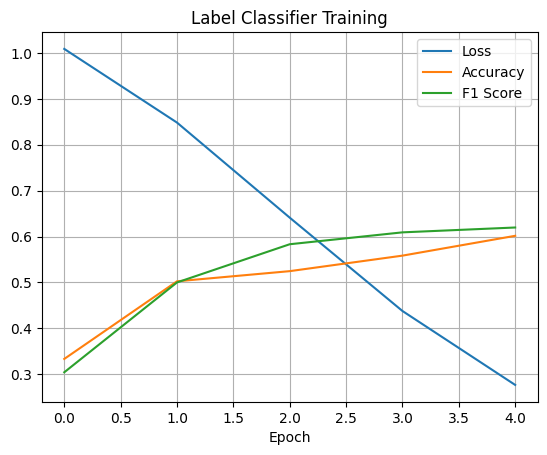

Model saved to /content/drive/MyDrive/COMP90042/result/bert_label_model_20250524_084428.pth


In [ ]:
# Load datasets
train_data = generate_label_classification_samples(
    claims_paths=[DATA_DIR / "train-claims.json"], training=True
)
val_data = generate_label_classification_samples(
    claims_paths=[DATA_DIR / "dev-claims.json"], training=True
)

# Instantiate and train
label_model = BertLabelClassifier()
label_trainer = LabelTrainer(
    label_model, train_data, val_data,
    label_weights=[1.0, 0.6, 0.4]
)
label_trainer.train(epochs=5)

# Save model
model_path = RESULT_DIR / f"bert_label_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
# torch.save(label_model, model_path)
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

### Label Classification Inference

This cell performs the second stage of fact verification: **classifying the stance of a claim based on retrieved evidence** using a fine-tuned BERT classifier.

#### Pipeline Overview
- Loads retrieval results from `bert_retriver_claim_evidence.json`, containing each claim and its top-k evidence candidates.
- For each claim, constructs a small dataset of `(claim, evidence)` pairs.
- Uses a trained classifier (`BertLabelClassifier`) to predict a label for each pair.
- Aggregates all predictions per claim and assigns a final label using simple heuristics:
  - If both `SUPPORTS` and `REFUTES` are predicted → `DISPUTED`
  - Else if any `SUPPORTS` → `SUPPORTS`
  - Else if any `REFUTES` → `REFUTES`
  - Else → `NOT_ENOUGH_INFO`


In [ ]:
#  Label Classification Inference
def run_classification(model, tokenizer, retrieval_results):
    label_map = {0: "REFUTES", 1: "NOT_ENOUGH_INFO", 2: "SUPPORTS", 3: "DISPUTED"}
    runner = InferenceRunner(model, tokenizer)

    final_labels = retrieval_results.copy()
    for cid, record in tqdm(retrieval_results.items(), desc="Classifying Labels"):
        claim_text = record["claim_text"]
        evidences = record["evidences"]
        inputs = [(claim_text, eid) for eid in evidences]

        dataset = LabelClassificationDataset(
            claim_id=cid,
            claims_paths=[RESULT_DIR / "bert_retriver_claim_evidence.json"],
            evidence_path=EVIDENCE_FILE,
            training=False,
            verbose=False
        )
        loader = DataLoader(dataset, batch_size=16, shuffle=False)

        all_preds = []
        for batch in loader:
            claims, evidences, labels, *_ = batch
            input_pairs = list(zip(claims, evidences))
            probs = runner.predict_scores(input_pairs)
            preds = torch.argmax(probs, dim=1).tolist()
            all_preds.extend(preds)

        if 2 in all_preds and 0 in all_preds:
            final_labels[cid]["claim_label"] = label_map[3]
        elif 2 in all_preds:
            final_labels[cid]["claim_label"] = label_map[2]
        elif 0 in all_preds:
            final_labels[cid]["claim_label"] = label_map[0]
        else:
            final_labels[cid]["claim_label"] = label_map[1]

    with open(FINAL_OUTPUT, "w") as f:
        json.dump(final_labels, f)
        print(f"Saved final prediction to {FINAL_OUTPUT}")


# Load and run classification
LABEL_MODEL_PATH = RESULT_DIR / "bert_base_label_2025_0524_084428.pth"
RETRIEVAL_RESULT_PATH = RESULT_DIR / "bert_retriver_claim_evidence.json"
classification_model = BertLabelClassifier()
classification_model.load_state_dict(torch.load(LABEL_MODEL_PATH, map_location=DEVICE))
classification_model.to(DEVICE)
classification_model.eval()
classification_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


with open(RETRIEVAL_RESULT_PATH, "r") as f:
    retrieval_results_dict = json.load(f)
run_classification(classification_model, classification_tokenizer, retrieval_results_dict)

Classifying Labels:   1%|          | 1/153 [00:01<03:48,  1.50s/it]

generated dataset n=5


Classifying Labels:   1%|▏         | 2/153 [00:03<03:49,  1.52s/it]

generated dataset n=5


Classifying Labels:   2%|▏         | 3/153 [00:04<03:46,  1.51s/it]

generated dataset n=5


Classifying Labels:   3%|▎         | 4/153 [00:06<03:44,  1.50s/it]

generated dataset n=5


Classifying Labels:   3%|▎         | 5/153 [00:07<03:40,  1.49s/it]

generated dataset n=5


Classifying Labels:   4%|▍         | 6/153 [00:09<03:50,  1.57s/it]

generated dataset n=5


Classifying Labels:   5%|▍         | 7/153 [00:11<04:26,  1.82s/it]

generated dataset n=5


Classifying Labels:   5%|▌         | 8/153 [00:13<04:13,  1.75s/it]

generated dataset n=5


Classifying Labels:   6%|▌         | 9/153 [00:14<04:01,  1.68s/it]

generated dataset n=5


Classifying Labels:   7%|▋         | 10/153 [00:16<03:52,  1.63s/it]

generated dataset n=5


Classifying Labels:   7%|▋         | 11/153 [00:17<03:44,  1.58s/it]

generated dataset n=5


Classifying Labels:   8%|▊         | 12/153 [00:19<03:39,  1.56s/it]

generated dataset n=5


Classifying Labels:   8%|▊         | 13/153 [00:20<03:36,  1.54s/it]

generated dataset n=5


Classifying Labels:   9%|▉         | 14/153 [00:22<03:43,  1.61s/it]

generated dataset n=5


Classifying Labels:  10%|▉         | 15/153 [00:24<04:10,  1.82s/it]

generated dataset n=5


Classifying Labels:  10%|█         | 16/153 [00:26<03:56,  1.73s/it]

generated dataset n=5


Classifying Labels:  11%|█         | 17/153 [00:27<03:46,  1.67s/it]

generated dataset n=5


Classifying Labels:  12%|█▏        | 18/153 [00:29<03:40,  1.63s/it]

generated dataset n=5


Classifying Labels:  12%|█▏        | 19/153 [00:30<03:33,  1.59s/it]

generated dataset n=5


Classifying Labels:  13%|█▎        | 20/153 [00:32<03:28,  1.57s/it]

generated dataset n=5


Classifying Labels:  14%|█▎        | 21/153 [00:33<03:23,  1.54s/it]

generated dataset n=5


Classifying Labels:  14%|█▍        | 22/153 [00:35<03:35,  1.65s/it]

generated dataset n=5


Classifying Labels:  15%|█▌        | 23/153 [00:37<03:57,  1.83s/it]

generated dataset n=5


Classifying Labels:  16%|█▌        | 24/153 [00:39<03:44,  1.74s/it]

generated dataset n=5


Classifying Labels:  16%|█▋        | 25/153 [00:41<03:35,  1.68s/it]

generated dataset n=5


Classifying Labels:  17%|█▋        | 26/153 [00:42<03:27,  1.63s/it]

generated dataset n=5


Classifying Labels:  18%|█▊        | 27/153 [00:44<03:21,  1.60s/it]

generated dataset n=5


Classifying Labels:  18%|█▊        | 28/153 [00:45<03:16,  1.57s/it]

generated dataset n=5


Classifying Labels:  19%|█▉        | 29/153 [00:47<03:13,  1.56s/it]

generated dataset n=5


Classifying Labels:  20%|█▉        | 30/153 [00:49<03:30,  1.71s/it]

generated dataset n=5


Classifying Labels:  20%|██        | 31/153 [00:51<03:43,  1.83s/it]

generated dataset n=5


Classifying Labels:  21%|██        | 32/153 [00:52<03:30,  1.74s/it]

generated dataset n=5


Classifying Labels:  22%|██▏       | 33/153 [00:54<03:21,  1.68s/it]

generated dataset n=5


Classifying Labels:  22%|██▏       | 34/153 [00:55<03:14,  1.63s/it]

generated dataset n=5


Classifying Labels:  23%|██▎       | 35/153 [00:57<03:08,  1.60s/it]

generated dataset n=5


Classifying Labels:  24%|██▎       | 36/153 [00:58<03:03,  1.56s/it]

generated dataset n=5


Classifying Labels:  24%|██▍       | 37/153 [01:00<03:00,  1.55s/it]

generated dataset n=5


Classifying Labels:  25%|██▍       | 38/153 [01:02<03:18,  1.72s/it]

generated dataset n=5


Classifying Labels:  25%|██▌       | 39/153 [01:04<03:25,  1.80s/it]

generated dataset n=5


Classifying Labels:  26%|██▌       | 40/153 [01:06<03:14,  1.72s/it]

generated dataset n=5


Classifying Labels:  27%|██▋       | 41/153 [01:07<03:04,  1.65s/it]

generated dataset n=5


Classifying Labels:  27%|██▋       | 42/153 [01:09<02:59,  1.61s/it]

generated dataset n=5


Classifying Labels:  28%|██▊       | 43/153 [01:10<02:54,  1.59s/it]

generated dataset n=5


Classifying Labels:  29%|██▉       | 44/153 [01:12<02:53,  1.59s/it]

generated dataset n=5


Classifying Labels:  29%|██▉       | 45/153 [01:13<02:49,  1.57s/it]

generated dataset n=5


Classifying Labels:  30%|███       | 46/153 [01:15<03:08,  1.76s/it]

generated dataset n=5


Classifying Labels:  31%|███       | 47/153 [01:17<03:10,  1.79s/it]

generated dataset n=5


Classifying Labels:  31%|███▏      | 48/153 [01:19<03:00,  1.72s/it]

generated dataset n=5


Classifying Labels:  32%|███▏      | 49/153 [01:20<02:52,  1.66s/it]

generated dataset n=5


Classifying Labels:  33%|███▎      | 50/153 [01:22<02:46,  1.61s/it]

generated dataset n=5


Classifying Labels:  33%|███▎      | 51/153 [01:23<02:41,  1.58s/it]

generated dataset n=5


Classifying Labels:  34%|███▍      | 52/153 [01:25<02:36,  1.55s/it]

generated dataset n=5


Classifying Labels:  35%|███▍      | 53/153 [01:26<02:33,  1.54s/it]

generated dataset n=5


Classifying Labels:  35%|███▌      | 54/153 [01:29<02:55,  1.77s/it]

generated dataset n=5


Classifying Labels:  36%|███▌      | 55/153 [01:30<02:55,  1.79s/it]

generated dataset n=5


Classifying Labels:  37%|███▋      | 56/153 [01:32<02:44,  1.70s/it]

generated dataset n=5


Classifying Labels:  37%|███▋      | 57/153 [01:34<02:38,  1.65s/it]

generated dataset n=5


Classifying Labels:  38%|███▊      | 58/153 [01:35<02:32,  1.60s/it]

generated dataset n=5


Classifying Labels:  39%|███▊      | 59/153 [01:37<02:27,  1.57s/it]

generated dataset n=5


Classifying Labels:  39%|███▉      | 60/153 [01:38<02:24,  1.55s/it]

generated dataset n=5


Classifying Labels:  40%|███▉      | 61/153 [01:41<03:09,  2.06s/it]

generated dataset n=5


Classifying Labels:  41%|████      | 62/153 [01:44<03:24,  2.25s/it]

generated dataset n=5


Classifying Labels:  41%|████      | 63/153 [01:45<03:02,  2.02s/it]

generated dataset n=5


Classifying Labels:  42%|████▏     | 64/153 [01:47<02:46,  1.87s/it]

generated dataset n=5


Classifying Labels:  42%|████▏     | 65/153 [01:48<02:35,  1.76s/it]

generated dataset n=5


Classifying Labels:  43%|████▎     | 66/153 [01:50<02:27,  1.69s/it]

generated dataset n=5


Classifying Labels:  44%|████▍     | 67/153 [01:52<02:20,  1.63s/it]

generated dataset n=5


Classifying Labels:  44%|████▍     | 68/153 [01:53<02:15,  1.60s/it]

generated dataset n=5


Classifying Labels:  45%|████▌     | 69/153 [01:55<02:30,  1.79s/it]

generated dataset n=5


Classifying Labels:  46%|████▌     | 70/153 [01:57<02:29,  1.80s/it]

generated dataset n=5


Classifying Labels:  46%|████▋     | 71/153 [01:59<02:21,  1.73s/it]

generated dataset n=5


Classifying Labels:  47%|████▋     | 72/153 [02:00<02:15,  1.67s/it]

generated dataset n=5


Classifying Labels:  48%|████▊     | 73/153 [02:02<02:09,  1.62s/it]

generated dataset n=5


Classifying Labels:  48%|████▊     | 74/153 [02:03<02:05,  1.58s/it]

generated dataset n=5


Classifying Labels:  49%|████▉     | 75/153 [02:05<02:01,  1.56s/it]

generated dataset n=5


Classifying Labels:  50%|████▉     | 76/153 [02:06<01:58,  1.54s/it]

generated dataset n=5


Classifying Labels:  50%|█████     | 77/153 [02:08<02:13,  1.76s/it]

generated dataset n=5


Classifying Labels:  51%|█████     | 78/153 [02:10<02:13,  1.77s/it]

generated dataset n=5


Classifying Labels:  52%|█████▏    | 79/153 [02:12<02:05,  1.69s/it]

generated dataset n=5


Classifying Labels:  52%|█████▏    | 80/153 [02:13<01:59,  1.64s/it]

generated dataset n=5


Classifying Labels:  53%|█████▎    | 81/153 [02:15<01:55,  1.60s/it]

generated dataset n=5


Classifying Labels:  54%|█████▎    | 82/153 [02:16<01:51,  1.58s/it]

generated dataset n=5


Classifying Labels:  54%|█████▍    | 83/153 [02:18<01:48,  1.55s/it]

generated dataset n=5


Classifying Labels:  55%|█████▍    | 84/153 [02:19<01:48,  1.57s/it]

generated dataset n=5


Classifying Labels:  56%|█████▌    | 85/153 [02:22<02:02,  1.81s/it]

generated dataset n=5


Classifying Labels:  56%|█████▌    | 86/153 [02:23<01:59,  1.78s/it]

generated dataset n=5


Classifying Labels:  57%|█████▋    | 87/153 [02:25<01:51,  1.70s/it]

generated dataset n=5


Classifying Labels:  58%|█████▊    | 88/153 [02:27<01:47,  1.65s/it]

generated dataset n=5


Classifying Labels:  58%|█████▊    | 89/153 [02:28<01:42,  1.60s/it]

generated dataset n=5


Classifying Labels:  59%|█████▉    | 90/153 [02:30<01:39,  1.58s/it]

generated dataset n=5


Classifying Labels:  59%|█████▉    | 91/153 [02:31<01:36,  1.56s/it]

generated dataset n=5


Classifying Labels:  60%|██████    | 92/153 [02:33<01:36,  1.58s/it]

generated dataset n=5


Classifying Labels:  61%|██████    | 93/153 [02:35<01:48,  1.81s/it]

generated dataset n=5


Classifying Labels:  61%|██████▏   | 94/153 [02:37<01:43,  1.76s/it]

generated dataset n=5


Classifying Labels:  62%|██████▏   | 95/153 [02:38<01:37,  1.68s/it]

generated dataset n=5


Classifying Labels:  63%|██████▎   | 96/153 [02:40<01:33,  1.64s/it]

generated dataset n=5


Classifying Labels:  63%|██████▎   | 97/153 [02:41<01:30,  1.61s/it]

generated dataset n=5


Classifying Labels:  64%|██████▍   | 98/153 [02:43<01:26,  1.58s/it]

generated dataset n=5


Classifying Labels:  65%|██████▍   | 99/153 [02:44<01:24,  1.57s/it]

generated dataset n=5


Classifying Labels:  65%|██████▌   | 100/153 [02:46<01:29,  1.68s/it]

generated dataset n=5


Classifying Labels:  66%|██████▌   | 101/153 [02:49<01:36,  1.86s/it]

generated dataset n=5


Classifying Labels:  67%|██████▋   | 102/153 [02:50<01:29,  1.76s/it]

generated dataset n=5


Classifying Labels:  67%|██████▋   | 103/153 [02:52<01:24,  1.68s/it]

generated dataset n=5


Classifying Labels:  68%|██████▊   | 104/153 [02:53<01:20,  1.64s/it]

generated dataset n=5


Classifying Labels:  69%|██████▊   | 105/153 [02:55<01:17,  1.61s/it]

generated dataset n=5


Classifying Labels:  69%|██████▉   | 106/153 [02:56<01:14,  1.58s/it]

generated dataset n=5


Classifying Labels:  70%|██████▉   | 107/153 [02:58<01:11,  1.56s/it]

generated dataset n=5


Classifying Labels:  71%|███████   | 108/153 [03:00<01:15,  1.67s/it]

generated dataset n=5


Classifying Labels:  71%|███████   | 109/153 [03:02<01:20,  1.83s/it]

generated dataset n=5


Classifying Labels:  72%|███████▏  | 110/153 [03:03<01:14,  1.73s/it]

generated dataset n=5


Classifying Labels:  73%|███████▎  | 111/153 [03:05<01:10,  1.67s/it]

generated dataset n=5


Classifying Labels:  73%|███████▎  | 112/153 [03:06<01:06,  1.63s/it]

generated dataset n=5


Classifying Labels:  74%|███████▍  | 113/153 [03:08<01:03,  1.58s/it]

generated dataset n=5


Classifying Labels:  75%|███████▍  | 114/153 [03:09<01:01,  1.57s/it]

generated dataset n=5


Classifying Labels:  75%|███████▌  | 115/153 [03:11<00:59,  1.55s/it]

generated dataset n=5


Classifying Labels:  76%|███████▌  | 116/153 [03:13<01:02,  1.70s/it]

generated dataset n=5


Classifying Labels:  76%|███████▋  | 117/153 [03:15<01:04,  1.80s/it]

generated dataset n=5


Classifying Labels:  77%|███████▋  | 118/153 [03:17<01:00,  1.73s/it]

generated dataset n=5


Classifying Labels:  78%|███████▊  | 119/153 [03:18<00:56,  1.67s/it]

generated dataset n=5


Classifying Labels:  78%|███████▊  | 120/153 [03:20<00:53,  1.63s/it]

generated dataset n=5


Classifying Labels:  79%|███████▉  | 121/153 [03:21<00:51,  1.60s/it]

generated dataset n=5


Classifying Labels:  80%|███████▉  | 122/153 [03:23<00:48,  1.57s/it]

generated dataset n=5


Classifying Labels:  80%|████████  | 123/153 [03:24<00:46,  1.55s/it]

generated dataset n=5


Classifying Labels:  81%|████████  | 124/153 [03:26<00:50,  1.75s/it]

generated dataset n=5


Classifying Labels:  82%|████████▏ | 125/153 [03:28<00:50,  1.80s/it]

generated dataset n=5


Classifying Labels:  82%|████████▏ | 126/153 [03:30<00:46,  1.72s/it]

generated dataset n=5


Classifying Labels:  83%|████████▎ | 127/153 [03:31<00:43,  1.67s/it]

generated dataset n=5


Classifying Labels:  84%|████████▎ | 128/153 [03:33<00:40,  1.62s/it]

generated dataset n=5


Classifying Labels:  84%|████████▍ | 129/153 [03:34<00:38,  1.59s/it]

generated dataset n=5


Classifying Labels:  85%|████████▍ | 130/153 [03:36<00:36,  1.57s/it]

generated dataset n=5


Classifying Labels:  86%|████████▌ | 131/153 [03:37<00:34,  1.56s/it]

generated dataset n=5


Classifying Labels:  86%|████████▋ | 132/153 [03:40<00:37,  1.81s/it]

generated dataset n=5


Classifying Labels:  87%|████████▋ | 133/153 [03:42<00:36,  1.80s/it]

generated dataset n=5


Classifying Labels:  88%|████████▊ | 134/153 [03:43<00:32,  1.72s/it]

generated dataset n=5


Classifying Labels:  88%|████████▊ | 135/153 [03:45<00:29,  1.66s/it]

generated dataset n=5


Classifying Labels:  89%|████████▉ | 136/153 [03:46<00:27,  1.63s/it]

generated dataset n=5


Classifying Labels:  90%|████████▉ | 137/153 [03:48<00:25,  1.59s/it]

generated dataset n=5


Classifying Labels:  90%|█████████ | 138/153 [03:49<00:23,  1.59s/it]

generated dataset n=5


Classifying Labels:  91%|█████████ | 139/153 [03:51<00:22,  1.62s/it]

generated dataset n=5


Classifying Labels:  92%|█████████▏| 140/153 [03:53<00:24,  1.85s/it]

generated dataset n=5


Classifying Labels:  92%|█████████▏| 141/153 [03:55<00:21,  1.77s/it]

generated dataset n=5


Classifying Labels:  93%|█████████▎| 142/153 [03:56<00:18,  1.70s/it]

generated dataset n=5


Classifying Labels:  93%|█████████▎| 143/153 [03:58<00:16,  1.65s/it]

generated dataset n=5


Classifying Labels:  94%|█████████▍| 144/153 [04:00<00:14,  1.61s/it]

generated dataset n=5


Classifying Labels:  95%|█████████▍| 145/153 [04:01<00:12,  1.59s/it]

generated dataset n=5


Classifying Labels:  95%|█████████▌| 146/153 [04:03<00:10,  1.57s/it]

generated dataset n=5


Classifying Labels:  96%|█████████▌| 147/153 [04:04<00:09,  1.65s/it]

generated dataset n=5


Classifying Labels:  97%|█████████▋| 148/153 [04:07<00:09,  1.84s/it]

generated dataset n=5


Classifying Labels:  97%|█████████▋| 149/153 [04:08<00:06,  1.74s/it]

generated dataset n=5


Classifying Labels:  98%|█████████▊| 150/153 [04:10<00:05,  1.68s/it]

generated dataset n=5


Classifying Labels:  99%|█████████▊| 151/153 [04:11<00:03,  1.64s/it]

generated dataset n=5


Classifying Labels:  99%|█████████▉| 152/153 [04:13<00:01,  1.62s/it]

generated dataset n=5


Classifying Labels: 100%|██████████| 153/153 [04:14<00:00,  1.67s/it]

generated dataset n=5


Saved final prediction to /content/drive/MyDrive/COMP90042/data/test-claims-predictions.json


### Final Predictions

The final output, `final_predictions`, is a dictionary mapping each test claim ID to one of the labels:

- `SUPPORTS`  
- `REFUTES`  
- `NOT_ENOUGH_INFO`  
- `DISPUTED`  

We have now completed the claim verification pipeline:

- Retrieved evidence for each claim using a trained retrieval model  
- Classified each claim based on its evidence  
- Handled `DISPUTED` cases by detecting conflicting evidence predictions  

This end-to-end approach combines information retrieval with natural language understanding.

The final predictions are saved in `test-claims-predictions.json`.  
They can be evaluated against ground-truth labels, submitted to a leaderboard, or used in further analysis.